###### 5.삼성전자주식 다음달 가격(미래 30일의 종가) 얼마일까??
###### 6.비트코인 다음 달 어떻게 될까?
###### 7.전날 비트코인 상승시 다음날 주가와의 상관관계
1. 목표
2. 데이터획득
3. 데이터정제
4. 전처리
5. 입력X/출력y 분리 (X로부터 y를 출력하겠다.)
6. train(학습용)/test(검증용) 분리
7. 학습용데이터로 학습, 성능 측정
8. 그래프 시각화
Y:미래 30일의 국내 특정 주식과 비트코인의 종가
X:최근 60일간의 데이터
Step:하루간격
양:1년(2018.06월~2019년.06월)
데이터획득: 국내기업 1개, 비트코인
데이터정제: 누락, 특수기호, 문자>수치 변환
두 데이터 날짜 기준으로 통합(asix = 1)
- 외국 (2018-01-01), 국내(2018.01.01), (2018.01.01)
- 날짜포맷을 (YYYY-MM-DD)으로 변환 후 통합
입력X/출력y 분리
- m개의 x,y쌍
- x(m,60,15)(국내증시컬럼+비트코인컬럼) > reshape > (m, 60*15)
- y(m,30,1) = (m,30)
비트코인 가격 변화와 주가와의 상관관계: cov()
학습용/검증용 분리
- 썩으면 안되므로 직접 분리
- 가장 과거의 데이터 10%를 검증용으로 사용
Ridge 모델. 학습용 데이터로 학습
미래의 예측: predict(x(1, 60*15)) > return > y_hat(1, 20*2)
미래 예측: (1,30*2) > (30,2) > 국내(30), 비트코인(30) > 그래프로 그리기

국내기업 1년 데이터 획득

In [27]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [39]:
#주소중간에 _day가 추가됨
samsung_url = 'https://finance.naver.com/item/sise_day.nhn?code=005930'

In [12]:
tables = pd.read_html(samsung_url + '&page='+str(1))
len(tables)
samsung=tables[0]
samsung.shape

(15, 7)

In [48]:
# 각페이지의 테이블들을 테이블리스트에 집어넣기
samsungs = []
for i in range(1,28):
    tables = pd.read_html(samsung_url+'&page='+str(i))
    samsung =tables[0]
    samsungs.append(samsung)
len(samsungs)

27

In [49]:
#테이블리스트에 있는것들을 하나의 큰테이블로 합침
samsung = pd.concat(samsungs, axis =0)
samsung.shape

(405, 7)

In [50]:
samsung.tail()

,날짜,종가,전일비,시가,고가,저가,거래량
10,2018.05.31,50700.0,1200.0,50400.0,50800.0,49850.0,63491109.0
11,2018.05.30,49500.0,1800.0,51300.0,51500.0,49100.0,20498098.0
12,2018.05.29,51300.0,1000.0,52200.0,52500.0,51300.0,8480437.0
13,2018.05.28,52300.0,400.0,52500.0,53000.0,52000.0,9787820.0
14,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [9]:
#몇번째 테이블이 일일데이터일까 찾기
for t in tables:
    print(t.shape)

(15, 7)
(1, 12)


In [51]:
bitcoin_url = 'https://coinmarketcap.com/currencies/bitcoin/historical-data/'
bitcoin_url +='?start=20180601&end=20190601'
tables = pd.read_html(bitcoin_url)
bitcoin = tables[0]
len(tables)

2

In [52]:
samsung.head()

,날짜,종가,전일비,시가,고가,저가,거래량
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2019.07.03,45650.0,600.0,45750.0,46350.0,45600.0,3781862.0
2,2019.07.02,46250.0,350.0,46200.0,46900.0,45850.0,8463073.0
3,2019.07.01,46600.0,400.0,47350.0,47400.0,46250.0,11383522.0
4,2019.06.28,47000.0,500.0,47000.0,47000.0,46700.0,12949231.0


In [ ]:
두데이터 날짜 기준으로 통합(asix  =1)
외국(2018-01-01), 국내(2018.01.01), (18.01.01)
날짜포맷을 (YYYY,MM,DD)으로 변환 후 통합

In [53]:
#삼성데이터는 날짜 컬럼을 인덱스로 둠
samsung = samsung.set_index('날짜')
#비트코인은 date를 인덱스로 둠
bitcoin = bitcoin.set_index('Date')

In [54]:
bitcoin.head()

,Open*,High,Low,Close**,Volume,Market Cap
Date,,,,,,
"Jun 01, 2019",8573.84,8625.60,8481.58,8564.02,22488303544,151890214310
"May 31, 2019",8320.29,8586.66,8172.55,8574.50,25365190957,152059886414
"May 30, 2019",8661.76,9008.31,8221.27,8319.47,29246528551,147525141134
"May 29, 2019",8718.59,8755.85,8482.73,8659.49,23473479966,153537047655
"May 28, 2019",8802.76,8807.02,8634.72,8719.96,24226919267,154590202287


In [55]:
samsung.head()

,종가,전일비,시가,고가,저가,거래량
날짜,,,,,,
NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019.07.03,45650.0,600.0,45750.0,46350.0,45600.0,3781862.0
2019.07.02,46250.0,350.0,46200.0,46900.0,45850.0,8463073.0
2019.07.01,46600.0,400.0,47350.0,47400.0,46250.0,11383522.0
2019.06.28,47000.0,500.0,47000.0,47000.0,46700.0,12949231.0


In [57]:
samsung.index

Index([         nan, '2019.07.03', '2019.07.02', '2019.07.01', '2019.06.28',
       '2019.06.27',          nan,          nan,          nan, '2019.06.26',
       ...
       '2018.06.04',          nan,          nan,          nan, '2018.06.01',
       '2018.05.31', '2018.05.30', '2018.05.29', '2018.05.28',          nan],
      dtype='object', name='날짜', length=405)

In [58]:
bitcoin.index

Index(['Jun 01, 2019', 'May 31, 2019', 'May 30, 2019', 'May 29, 2019',
       'May 28, 2019', 'May 27, 2019', 'May 26, 2019', 'May 25, 2019',
       'May 24, 2019', 'May 23, 2019',
       ...
       'Jun 10, 2018', 'Jun 09, 2018', 'Jun 08, 2018', 'Jun 07, 2018',
       'Jun 06, 2018', 'Jun 05, 2018', 'Jun 04, 2018', 'Jun 03, 2018',
       'Jun 02, 2018', 'Jun 01, 2018'],
      dtype='object', name='Date', length=366)

In [59]:
#삼성과 비트코인의 인덱스 타입을 YYYY-MM-DD포맷으로 통일해줌, 안하면 concat이 안됨
pd.to_datetime(bitcoin.index)

DatetimeIndex(['2019-06-01', '2019-05-31', '2019-05-30', '2019-05-29',
               '2019-05-28', '2019-05-27', '2019-05-26', '2019-05-25',
               '2019-05-24', '2019-05-23',
               ...
               '2018-06-10', '2018-06-09', '2018-06-08', '2018-06-07',
               '2018-06-06', '2018-06-05', '2018-06-04', '2018-06-03',
               '2018-06-02', '2018-06-01'],
              dtype='datetime64[ns]', name='Date', length=366, freq=None)

In [60]:
pd.to_datetime(samsung.index)

DatetimeIndex([       'NaT', '2019-07-03', '2019-07-02', '2019-07-01',
               '2019-06-28', '2019-06-27',        'NaT',        'NaT',
                      'NaT', '2019-06-26',
               ...
               '2018-06-04',        'NaT',        'NaT',        'NaT',
               '2018-06-01', '2018-05-31', '2018-05-30', '2018-05-29',
               '2018-05-28',        'NaT'],
              dtype='datetime64[ns]', name='날짜', length=405, freq=None)

In [61]:
#삼성과 비트코인의 인덱스 타입을 YYYY-MM-DD포맷으로 통일해줌, 안하면 concat이 안됨
bitcoin.index = pd.to_datetime(bitcoin.index)
samsung.index = pd.to_datetime(samsung.index)

In [63]:
bitcoin.head()

,Open*,High,Low,Close**,Volume,Market Cap
Date,,,,,,
2019-06-01,8573.84,8625.60,8481.58,8564.02,22488303544,151890214310
2019-05-31,8320.29,8586.66,8172.55,8574.50,25365190957,152059886414
2019-05-30,8661.76,9008.31,8221.27,8319.47,29246528551,147525141134
2019-05-29,8718.59,8755.85,8482.73,8659.49,23473479966,153537047655
2019-05-28,8802.76,8807.02,8634.72,8719.96,24226919267,154590202287


In [64]:
samsung.head()

,종가,전일비,시가,고가,저가,거래량
날짜,,,,,,
NaT,NaN,NaN,NaN,NaN,NaN,NaN
2019-07-03,45650.0,600.0,45750.0,46350.0,45600.0,3781862.0
2019-07-02,46250.0,350.0,46200.0,46900.0,45850.0,8463073.0
2019-07-01,46600.0,400.0,47350.0,47400.0,46250.0,11383522.0
2019-06-28,47000.0,500.0,47000.0,47000.0,46700.0,12949231.0


In [67]:
#삼성과 비트코인 데이터를 인덱스를 기준으로 가로방향으로 붙이고 non을 삭제
df = pd.concat((samsung, bitcoin), axis = 1).dropna()
df.shape

(244, 12)

In [68]:
df.dtypes #문자타입이 있는지 확인

종가            float64
전일비           float64
시가            float64
고가            float64
저가            float64
거래량           float64
Open*         float64
High          float64
Low           float64
Close**       float64
Volume        float64
Market Cap    float64
dtype: object

In [ ]:
df.isna().sum() #non이 있는지 확인 후 아랫줄에 통계치 출력

In [69]:
df.describe() #통계치출력

,종가,전일비,시가,고가,저가,거래량,Open*,High,Low,Close**,Volume,Market Cap
count,244.000000,244.000000,244.000000,244.000000,244.000000,2.440000e+02,244.000000,244.000000,244.000000,244.000000,2.440000e+02,2.440000e+02
mean,44541.393443,524.590164,44541.393443,44982.786885,44080.122951,1.127346e+07,5598.614672,5708.022869,5487.953197,5597.538361,8.087400e+09,9.730654e+10
std,2616.501077,445.496251,2663.568359,2616.332608,2605.084532,3.923683e+06,1514.608753,1542.730010,1476.931675,1512.541132,6.225952e+09,2.597773e+10
min,37450.000000,0.000000,37450.000000,37600.000000,36850.000000,4.762460e+06,3253.120000,3329.560000,3206.540000,3242.480000,3.230550e+09,5.649438e+10
25%,43012.500000,200.000000,43012.500000,43437.500000,42400.000000,8.298381e+06,3957.602500,4031.850000,3899.502500,3956.197500,4.324805e+09,6.936442e+10
50%,44975.000000,400.000000,44925.000000,45500.000000,44500.000000,1.079669e+07,6205.425000,6300.355000,6029.725000,6179.620000,5.304537e+09,1.064328e+11
75%,46362.500000,762.500000,46462.500000,46850.000000,46000.000000,1.305694e+07,6599.830000,6743.025000,6498.092500,6601.707500,9.347169e+09,1.140496e+11
max,51300.000000,2200.000000,51800.000000,51800.000000,50700.000000,2.625465e+07,8802.760000,9008.310000,8668.700000,8805.780000,3.316720e+10,1.560938e+11


In [71]:
df.cov()#상관관계

,종가,전일비,시가,고가,저가,거래량,Open*,High,Low,Close**,Volume,Market Cap
종가,6.846078e+06,-1.755498e+04,6.807220e+06,6.780417e+06,6.748902e+06,-1.768174e+09,1.509873e+06,1.509372e+06,1.519761e+06,1.530810e+06,-1.766514e+12,2.530176e+13
전일비,-1.755498e+04,1.984669e+05,-1.146445e+04,2.638181e+04,-4.971497e+04,8.561799e+08,-1.569126e+04,-2.158713e+04,-1.742792e+04,-2.561715e+04,-1.813583e+11,-4.628508e+11
시가,6.807220e+06,-1.146445e+04,7.094596e+06,6.898380e+06,6.874931e+06,-1.543646e+09,1.544614e+06,1.544355e+06,1.547371e+06,1.560183e+06,-1.646136e+12,2.579749e+13
고가,6.780417e+06,2.638181e+04,6.898380e+06,6.845196e+06,6.757650e+06,-1.307755e+09,1.532320e+06,1.531849e+06,1.541699e+06,1.551951e+06,-1.657222e+12,2.567207e+13
저가,6.748902e+06,-4.971497e+04,6.874931e+06,6.757650e+06,6.786465e+06,-1.902252e+09,1.518191e+06,1.521359e+06,1.524395e+06,1.540312e+06,-1.758229e+12,2.544846e+13
거래량,-1.768174e+09,8.561799e+08,-1.543646e+09,-1.307755e+09,-1.902252e+09,1.539529e+13,-6.895658e+08,-7.620610e+08,-6.713624e+08,-7.452021e+08,8.860541e+14,-1.248894e+16
Open*,1.509873e+06,-1.569126e+04,1.544614e+06,1.532320e+06,1.518191e+06,-6.895658e+08,2.294040e+06,2.326722e+06,2.226557e+06,2.271367e+06,1.577697e+12,3.895097e+13
High,1.509372e+06,-2.158713e+04,1.544355e+06,1.531849e+06,1.521359e+06,-7.620610e+08,2.326722e+06,2.380016e+06,2.264298e+06,2.324452e+06,1.850203e+12,3.988235e+13
Low,1.519761e+06,-1.742792e+04,1.547371e+06,1.541699e+06,1.524395e+06,-6.713624e+08,2.226557e+06,2.264298e+06,2.181327e+06,2.226544e+06,1.453797e+12,3.818191e+13
Close**,1.530810e+06,-2.561715e+04,1.560183e+06,1.551951e+06,1.540312e+06,-7.452021e+08,2.271367e+06,2.324452e+06,2.226544e+06,2.287781e+06,1.706507e+12,3.925147e+13


In [75]:
df.head()

,종가,전일비,시가,고가,저가,거래량,Open*,High,Low,Close**,Volume,Market Cap
2018-06-01,51300.0,600.0,50500.0,51700.0,49950.0,13038499.0,7500.70,7604.73,7407.34,7541.45,4.921460e+09,1.287259e+11
2018-06-04,51100.0,200.0,50800.0,51200.0,50700.0,9767171.0,7722.53,7753.82,7474.04,7514.47,4.993170e+09,1.283122e+11
2018-06-05,51300.0,200.0,51100.0,51400.0,50400.0,9144100.0,7500.90,7643.23,7397.00,7633.76,4.961740e+09,1.303659e+11
2018-06-07,50600.0,700.0,51800.0,51800.0,50500.0,13590016.0,7650.82,7741.27,7650.82,7678.24,4.485800e+09,1.311532e+11
2018-06-08,49650.0,950.0,50200.0,50400.0,49600.0,16951706.0,7685.14,7698.19,7558.40,7624.92,4.227580e+09,1.302562e+11


In [92]:
비트코인변화 = df['Open*'] - df['Close**']
주가변화 = df['시가'] - df['종가']
과거비트코인변화 = 비트코인변화.iloc[:-1]
다음날주가변화 = 주가변화.iloc[1:]

In [94]:
비트코인변화

2018-06-01    -40.75
2018-06-04    208.06
2018-06-05   -132.86
2018-06-07    -27.42
2018-06-08     60.22
2018-06-11   -107.63
2018-06-12    323.46
2018-06-14   -332.60
2018-06-15    217.50
2018-06-18   -224.75
2018-06-19    -27.55
2018-06-20     -5.79
2018-06-21     50.35
2018-06-22    654.19
2018-06-25    -77.21
2018-06-26    159.88
2018-06-27    -72.73
2018-06-28    249.72
2018-06-29   -320.17
2018-07-02   -233.80
2018-07-03     67.07
2018-07-04    -46.68
2018-07-05    -39.43
2018-07-06    -34.81
2018-07-09     33.33
2018-07-10    409.26
2018-07-11    -63.94
2018-07-12    167.97
2018-07-13     -3.02
2018-07-16   -384.74
               ...  
2019-04-18    -46.91
2019-04-19     -5.66
2019-04-22    -86.88
2019-04-23   -172.99
2019-04-24    106.64
2019-04-25    256.00
2019-04-26    -69.05
2019-04-29     37.51
2019-04-30   -103.00
2019-05-02   -102.86
2019-05-03   -262.74
2019-05-07    -83.90
2019-05-08   -132.98
2019-05-09   -192.21
2019-05-10   -203.03
2019-05-13   -843.74
2019-05-14   

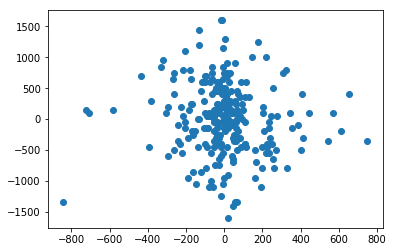

In [83]:
plt.scatter(과거비트코인변화, 다음날주가변화)

In [88]:
np.corrcoef(과거비트코인변화, 다음날주가변화),
#상관계수가 0에 가까우므로 둘은 상관관계가 거의 없음

(array([[ 1.        , -0.07316871],
        [-0.07316871,  1.        ]]),)

In [138]:
len(df)

244

In [97]:

input_seq = 60
output_seq = 30
m = len(df) - (input_seq + output_seq)+1
len(df), m

(244, 155)

In [149]:
df = df/df.sum()
#min_max
df - (df-df.min())/(df.max()-df.min()) #min_max정규화 (0~1사이로 값이 일치됨)
x_list = []
y_list = []
for i in range(m): #가장최근 60일, 30일을 기준으로 잡기위함
    x = df.iloc[i:i+input_seq]
    y =df.iloc[i+input_seq:i+input_seq+output_seq][['종가', 'Close**']]
    #rint(x.shape, y.shape)
    x_list.append(x)
    y_list.append(y)

In [150]:
len(x_list), type(x_list) #(155,60,12)
#155개를 스택에 쌓음
x_3d = np.stack(x_list, axis = 0)
y_3d = np.stack(y_list, axis = 0)
x_3d.shape, y_3d.shape

((155, 60, 12), (155, 30, 2))

In [151]:
test_ratio = 0.1
test_m = int(len(x_3d)*test_ratio)
test_m

15

In [152]:
m = len(x_3d)
x_2d = np.reshape(x_3d, [m, -1])#-1로 하면 컬럼쪽을 알아서 자동으로 2차원으로 맞춰줌...
y_2d = np.reshape(y_3d, [m, -1])
x_test = x_2d[:test_m]
x_train = x_2d[test_m:]
y_test = y_2d[:test_m]
y_train = y_2d[test_m:]

In [153]:
#model, Linear Regression, 가중치를 작게 제약시킨다. > 모든정보를 활용해서 예측
from sklearn.linear_model import Ridge
model = Ridge(normalize = True, solver='lsqr').fit(x_train, y_train) #2차원 이하만 가능

In [154]:
model.score(x_train, y_train), model.score(x_test, y_test)#과적합 발생

(0.9795854495349554, -28.641110527395576)

In [156]:
#가장최근데이터
recent = df.iloc[-input_seq:]
recent.shape
recent = np.reshape(np.array(recent), [1, -1])
recent.shape

(1, 720)

In [157]:
p = model.predict(recent) #미래예측
p = np.reshape(p, [output_seq, -1])
p.shape

(30, 2)

In [105]:
korea_close_index = 0
bitcoin_close_index = 9

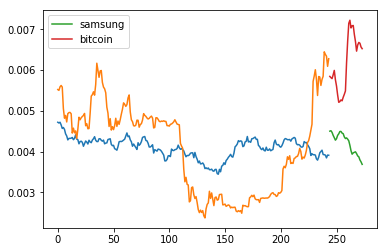

In [158]:
xm = len(df)
plt.plot(np.arange(xm), df['종가'].values)
plt.plot(np.arange(xm), df['Close**'].values)
plt.plot(np.arange(xm, xm+output_seq), p[:, 0], label='samsung')
plt.plot(np.arange(xm, xm+output_seq), p[:, 1], label='bitcoin')
plt.legend()